## build the real yolo

In [2]:
from keras.preprocessing import image
import numpy as np
import os
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
%matplotlib inline 
import matplotlib.patches as patches
import xml.etree.ElementTree as ET

Using TensorFlow backend.


In [135]:
# show the bound box
def anno_file_to_rect(anno_file):
    tree = ET.parse(anno_file)
    objs = tree.getroot().findall("object")
    boxes = [obj.find("bndbox") for obj in objs]
    return [(int(box.find("xmin").text), 
              int(box.find("ymin").text), 
              int(box.find("xmax").text), 
              int(box.find("ymax").text)) for box in boxes][0]

def get_image_size(af):
    tree = ET.parse(af)
    objs = tree.getroot().findall("object")
    boxes = [obj.find("bndbox") for obj in objs]
    image_size_el = tree.getroot().find("size")
    return (float(image_size_el.find("width").text), float(image_size_el.find("height").text))

## return 7 x 7 * 5(C, cx, cy, hx, hy)
def anno_file_to_yolo_y(af, grid = (7 , 7)):
    tree = ET.parse(af)
    objs = tree.getroot().findall("object")
    boxes = [obj.find("bndbox") for obj in objs]
    image_size_el = tree.getroot().find("size")
    image_width = float(image_size_el.find("width").text)
    image_height = float(image_size_el.find("height").text)
    cell_width = image_width / grid[0]
    cell_height = image_height / grid[1]
    
    rect = [(float(box.find("xmin").text), 
          float(box.find("ymin").text), 
          float(box.find("xmax").text), 
          float(box.find("ymax").text)) for box in boxes][0]

    width = rect[2] - rect[0]
    height = rect[3] - rect[1]
    center_x = (rect[2] + rect[0]) / 2.0
    center_y = (rect[3] + rect[1]) / 2.0
    
    # find which cell is the 1 one
    cell_idx_x = int(center_x * grid[0] / image_width)
    cell_idx_y = int(center_y * grid[1] / image_height)
    print "find center idx", cell_idx_x, cell_idx_y
    
    y1 = [1, 
          center_x / cell_width - cell_idx_x, 
          center_y / cell_height - cell_idx_y,
          width / image_width,
          height / image_height
         ]
    
    y = np.zeros((5 * grid[0] * grid[1]), dtype=np.float16)
    base = cell_idx_x  + cell_idx_y * grid[0]
    print "base idx", base
    y[base * 5: (base + 1) * 5] = y1
    
    return y


In [50]:
# random one image
idx = np.random.randint(0, 100)
print idx
anno_dir = "/Users/xuan/work/dataset/Annotation/n02085620-Chihuahua"
img_dir = "/Users/xuan/work/dataset/dogs/n02085620"
image_file = os.listdir(anno_dir)[idx]
print image_file
anno_file = anno_dir + "/" + image_file
image_file = img_dir + "/" + image_file + ".JPEG"
print "anno & img file as", anno_file, image_file
assert(os.path.exists(anno_file))
assert(os.path.exists(image_file))

97
n02085620_1321
anno & img file as /Users/xuan/work/dataset/Annotation/n02085620-Chihuahua/n02085620_1321 /Users/xuan/work/dataset/dogs/n02085620/n02085620_1321.JPEG


In [126]:
a = np.zeros(10)
a.shape
a[1:2] = [1]
a += 1
a.shape[0]
a = np.hstack(np.array([[1,0,0,0,0]] * 2))
b = np.hstack(np.array([[0,0,0,0,0,1,0.3,0.5,2,1]] ))

print np.argmax(a * b)

5


/Library/Python/2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


truth rect (111, 42, 248, 314)

for grid (1, 1)
find center idx 0 0
base idx 0
find cell 0 cell x 0 cell y 0 base 0
image width & height 500.0 333.0
cell width & height 500.0 333.0
calc C, cy, cy, h, w 1.0 0.35889 0.53467 0.81689 0.27393
calced as [ 114.60360075   45.67318083  140.60457732  275.6675656 ]

for grid (2, 2)
find center idx 0 1
base idx 2
find cell 2 cell x 0 cell y 1 base 10
image width & height 500.0 333.0
cell width & height 250.0 166.5
calc C, cy, cy, h, w 1.0 0.71777 0.069092 0.81689 0.27393
calced as [ 116.46877546   47.49770613  142.46975203  277.53274031]

for grid (3, 3)
find center idx 1 1
base idx 4
find cell 4 cell x 1 cell y 1 base 20
image width & height 500.0 333.0
cell width & height 166.666666667 111.0
calc C, cy, cy, h, w 1.0 0.077026 0.60352 0.81689 0.27393
calced as [ 114.96870993   45.92305563  140.90865134  275.97163962]


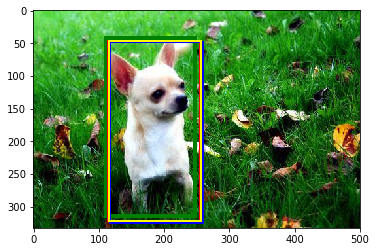

In [137]:
_, ax = plt.subplots(1)
ax.imshow(imread(image_file))

## truth bound box
rect = anno_file_to_rect(anno_file)
patch = patches.Rectangle((rect[0],rect[1]),rect[2] - rect[0],rect[3] - rect[1],linewidth=4,edgecolor='g',facecolor='none')
ax.add_patch(patch)
print "truth rect", rect

## but calced as
(image_width, image_height) = get_image_size(anno_file)
colors = ["red", "blue", "yellow", "dark"]
for g in range(1, 4):
    print ""
    print "for grid", (g,g)
    color = colors[g - 1]
    y = anno_file_to_yolo_y(anno_file, grid = (g, g))
    cell = np.argmax(np.hstack(np.array([[1,0,0,0,0]] * (g * g))) * y) / 5 
    cell_x = cell % g
    cell_y = cell // g
    base = cell * 5
    print "find cell", cell,"cell x", cell_x, "cell y", cell_y, "base", base
    (C, cx, cy, w, h) = y[base  : base + 5]
    cell_width = float(image_width) / g
    cell_height = float(image_height) / g
    
    print "image width & height", image_width, image_height
    print "cell width & height", cell_width, cell_height
    print "calc C, cy, cy, h, w", C, cx, cy, h, w
    # draw in image

    rect = np.array([(cell_x + cx - w * g / 2.0 ) * cell_width, 
            (cell_y + cy - h * g / 2.0 ) * cell_height, 
            w * image_width, 
            h * image_height])
    rect += np.random.uniform(0,6)
    print "calced as", rect
    patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2,edgecolor=color,facecolor='none')
    ax.add_patch(patch)
#     patch = patches.Ractangle((cx * image_width, cy * image_height), 4, linewidth=1,color='r',fill='full')
#     ax.add_patch(patch)

plt.show()